In [1]:
from pandas import read_csv
import numpy as np
import pandas as pd
from scipy.stats import pointbiserialr, pearsonr
import matplotlib
from matplotlib import pyplot
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import os
import warnings
from sklearn import preprocessing
from sklearn.preprocessing import scale
from sklearn.metrics import silhouette_samples, silhouette_score


In [2]:
#Código para cargar el Dataset
url = 'https://raw.githubusercontent.com/brubiog/TIA/main/dataset.csv'
dataset = read_csv(url,sep=";")


In [3]:
warnings.filterwarnings('ignore')

In [4]:
#Transformamos los datos: convertimos las categorías a numéricas para poder modelar
from sklearn.preprocessing import LabelEncoder
data_mapped = {"Target": {"Dropout":0.0, "Graduate":1.0, "Enrolled":1.0}}
dataset=dataset.replace(data_mapped)
for column in dataset.columns:
    if dataset[column].dtype == 'object':
        try:
            dataset[column] = dataset[column].str.replace(',', '.').astype(float)
        except ValueError:
            le = LabelEncoder()
            dataset[column] = le.fit_transform(dataset[column])

# Verificar la conversión
#print(dataset)
#dataset.to_csv('datasetcreado.csv', index=True, sep=';', decimal=',')

In [5]:
# Vamos a calcular las correlaciones entre las variabes de entrada y la de salida
target = 'Target'
correlations = {}
for column in dataset.columns:
    if column != target:
        if pd.api.types.is_numeric_dtype(dataset[column]):
            try:
                corr, _ = pearsonr(dataset[column].astype(float), dataset[target].astype(float))
                correlations[column] = corr
            except Exception as e:
                print(f"Error calculating correlation for {column}: {e}")
# Convertir a un DataFrame para mejor visualización
correlation_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['Correlation with Target'])
# Filtrar valores NaN
correlation_df = correlation_df.dropna()
print(correlation_df)


                                                Correlation with Target
Marital status                                                -0.093712
Application mode                                              -0.198458
Application order                                              0.070485
Course                                                         0.033676
Daytime/evening attendance\t                                   0.080499
Previous qualification                                        -0.049379
Previous qualification (grade)                                 0.078208
Nacionality                                                   -0.008346
Mother's qualification                                        -0.064958
Father's qualification                                        -0.018295
Mother's occupation                                            0.021999
Father's occupation                                            0.024260
Admission grade                                                0

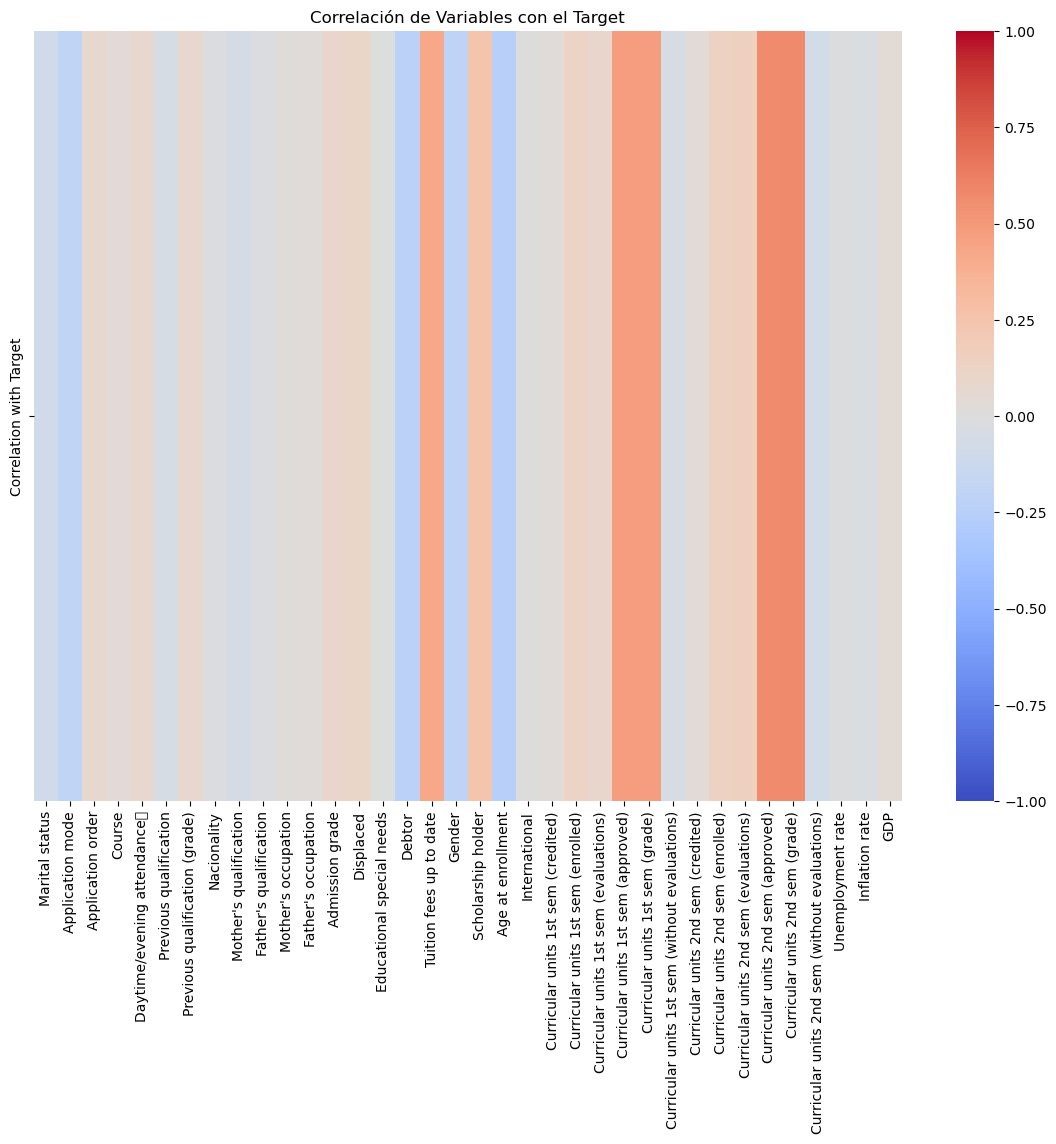

In [6]:
matplotlib.rc('font', family='DejaVu Sans')
# Crear el mapa de calor
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_df.T, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlación de Variables con el Target')
plt.show()


In [7]:
#Calculamos los estadísticos más importantes
Stats = dataset.describe()
Stats = Stats.transpose()
Stats

,count,mean,std,min,25%,50%,75%,max
Marital status,4424.0,1.178571,0.605747,1.00,1.00,1.00,1.00,6.00
Application mode,4424.0,18.669078,17.484682,1.00,1.00,17.00,39.00,57.00
Application order,4424.0,1.727848,1.313793,0.00,1.00,1.00,2.00,9.00
Course,4424.0,8856.642631,2063.566416,33.00,9085.00,9238.00,9556.00,9991.00
Daytime/evening attendance\t,4424.0,0.890823,0.311897,0.00,1.00,1.00,1.00,1.00
Previous qualification,4424.0,4.577758,10.216592,1.00,1.00,1.00,1.00,43.00
Previous qualification (grade),4424.0,132.613314,13.188332,95.00,125.00,133.10,140.00,190.00
Nacionality,4424.0,1.873192,6.914514,1.00,1.00,1.00,1.00,109.00
Mother's qualification,4424.0,19.561935,15.603186,1.00,2.00,19.00,37.00,44.00
Father's qualification,4424.0,22.275316,15.343108,1.00,3.00,19.00,37.00,44.00


### Primero un K-means con 2 variables

In [71]:
data = dataset[['Curricular units 2nd sem (approved)','Target']].copy()
data.reset_index(drop=True, inplace=True)

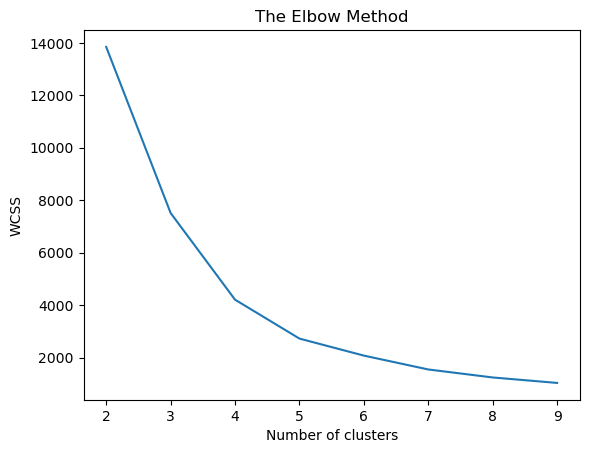

In [72]:
# Elbow Method
wcss = []
for i in range(2, 10):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(data)
    wcss.append(kmeans.inertia_)
plt.plot(range(2, 10), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


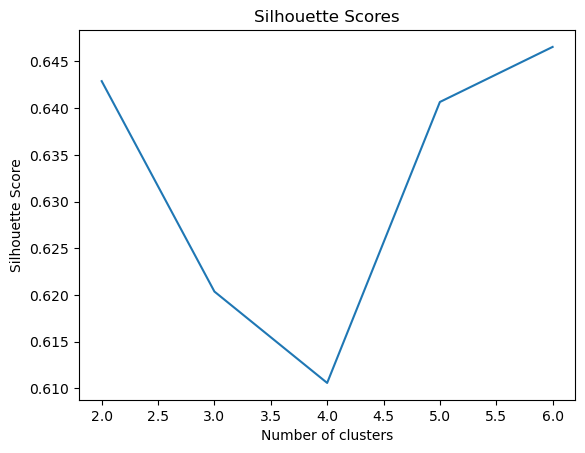

In [76]:
silhouette_scores = []
for i in range(2, 7):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(data)
    score = silhouette_score(data, kmeans.labels_)
    silhouette_scores.append(score)

plt.plot(range(2, 7), silhouette_scores)
plt.title('Silhouette Scores')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

Ahora con 5 cluster

In [81]:
data = dataset[['Curricular units 2nd sem (approved)','Target']].copy()
data.reset_index(drop=True, inplace=True)
if 'cluster' in data.columns:
    data.drop(columns=['cluster'], inplace=True)
kmeans = KMeans(n_clusters=5, init="k-means++", random_state=42).fit(data)
data['cluster'] = kmeans.labels_
centers = pd.DataFrame(kmeans.cluster_centers_, columns=['Curricular units 2nd sem (approved)', 'Target'])
centers['freq'] = data['cluster'].value_counts().values
centers['freq_r'] = data['cluster'].value_counts(normalize=True).values
print(centers)

   Curricular units 2nd sem (approved)    Target  freq    freq_r
0                            7.5712209 0.9345930  1691 0.3822333
1                            0.1158537 0.1737805   984 0.2224231
2                            5.5706682 0.8917800   897 0.2027577
3                           12.0365854 0.8475610   688 0.1555154
4                            3.2408027 0.6042363   164 0.0370705


In [82]:
# Silhouette Score
silhouette_scores = silhouette_samples(data.drop(columns=['cluster']), data['cluster'])
data['S_S'] = silhouette_scores
silhouette_score_mean = silhouette_score(data.drop(columns=['cluster']), data['cluster'])
print(silhouette_score_mean)

0.6393285418294008


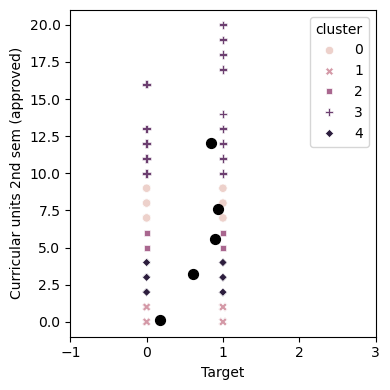

In [12]:
fig, ax = plt.subplots(figsize=(4, 4))
ax = sns.scatterplot(x='Target', y='Curricular units 2nd sem (approved)', hue='cluster', style='cluster', 
                     ax=ax, data=data)
ax.set_xlim(-1, 3)
ax.set_ylim(-1, 21) 
centers.plot.scatter(x='Target', y='Curricular units 2nd sem (approved)', ax=ax, s=50, color='black')
plt.tight_layout()
plt.show()

### Vamos con más variables: las 5 más correladas


In [83]:
data1 = dataset[['Curricular units 1st sem (grade)','Curricular units 2nd sem (grade)','Curricular units 1st sem (approved)',
                 'Curricular units 2nd sem (approved)','Tuition fees up to date','Target']].copy()
data1.reset_index(drop=True, inplace=True)

In [84]:
# Encontrar el número de clusters
# Establecer la variable de entorno OMP_NUM_THREADS
os.environ["OMP_NUM_THREADS"] = "15"
wcss = []
for i in range(2, 10):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42, n_init=10)
    kmeans.fit(data1)
    wcss.append(kmeans.inertia_)

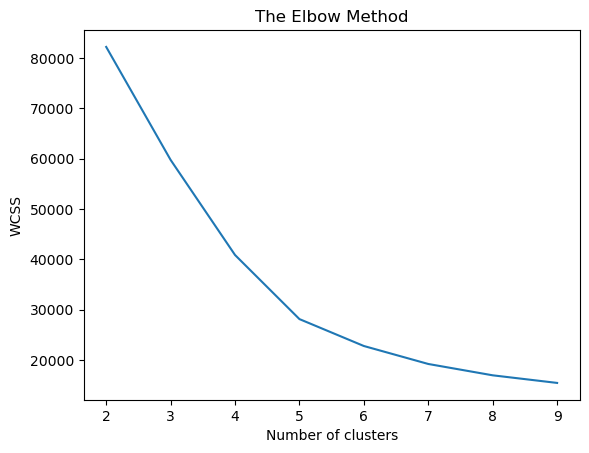

In [85]:
plt.plot(range(2, 10), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

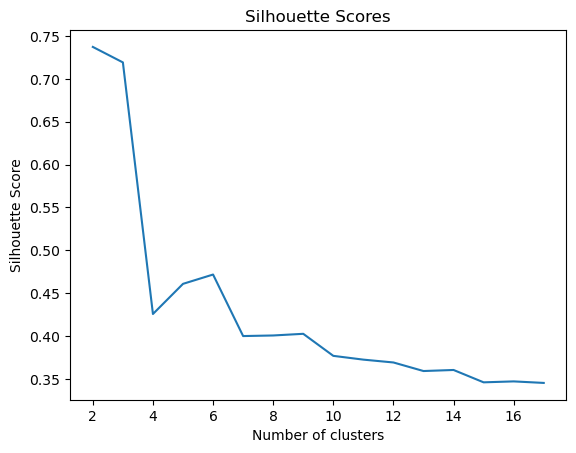

In [86]:
silhouette_scores = []
for i in range(2, 18):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=12, n_init=10)
    kmeans.fit(data1)
    score = silhouette_score(data1, kmeans.labels_)
    silhouette_scores.append(score)

plt.plot(range(2, 18), silhouette_scores)
plt.title('Silhouette Scores')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [17]:
warnings.filterwarnings('ignore')


**Probamos 3 cluster**

In [18]:
data1 = dataset[['Curricular units 1st sem (grade)','Curricular units 2nd sem (grade)','Curricular units 1st sem (approved)',
                 'Curricular units 2nd sem (approved)','Tuition fees up to date','Target']].copy()
data1.reset_index(drop=True, inplace=True)
if 'cluster' in data1.columns:
    data1.drop(columns=['cluster'], inplace=True)
kmeans = KMeans(n_clusters=3, init="k-means++", random_state=42).fit(data1)
data1['cluster'] = kmeans.labels_
centers = pd.DataFrame(kmeans.cluster_centers_, columns =['Curricular units 1st sem (grade)','Curricular units 2nd sem (grade)','Curricular units 1st sem (approved)',
                 'Curricular units 2nd sem (approved)','Tuition fees up to date','Target'])
centers['freq'] = data1['cluster'].value_counts().values
centers['freq_r'] = data1['cluster'].value_counts(normalize=True).values
pd.options.display.float_format = '{:.7f}'.format
print(centers)
centers.to_csv('6var3clus.csv',index=False, sep=';', decimal=',')

   Curricular units 1st sem (grade)  Curricular units 2nd sem (grade)  \
0                        12.7426693                        12.7474417   
1                        11.8448454                         0.0000000   
2                         0.0000000                         0.6486732   

   Curricular units 1st sem (approved)  Curricular units 2nd sem (approved)  \
0                            5.7840068                            5.5637450   
1                            2.5618557                           -0.0000000   
2                            0.0000000                            0.1019553   

   Tuition fees up to date    Target  freq    freq_r  
0                0.9262948 0.8093341  3514 0.7943038  
1                0.7010309 0.0670103   716 0.1618445  
2                0.7053073 0.2039106   194 0.0438517  


In [19]:
silhouette_scores = silhouette_samples(data1.drop(columns=['cluster']), data1['cluster'])
data1['S_S'] = silhouette_scores
silhouette_score_mean = silhouette_score(data1.drop(columns=['cluster']), data1['cluster'])
print(silhouette_score_mean)

0.7191080009887687


**Probamos 5 cluster**

In [20]:
data1 = dataset[['Curricular units 1st sem (grade)','Curricular units 2nd sem (grade)','Curricular units 1st sem (approved)',
                 'Curricular units 2nd sem (approved)','Tuition fees up to date','Target']].copy()
data1.reset_index(drop=True, inplace=True)
if 'cluster' in data1.columns:
    data1.drop(columns=['cluster'], inplace=True)
kmeans = KMeans(n_clusters=5, init="k-means++", random_state=42).fit(data1)
data1['cluster'] = kmeans.labels_
centers = pd.DataFrame(kmeans.cluster_centers_, columns =['Curricular units 1st sem (grade)','Curricular units 2nd sem (grade)','Curricular units 1st sem (approved)',
                 'Curricular units 2nd sem (approved)','Tuition fees up to date','Target'])
centers['freq'] = data1['cluster'].value_counts().values
centers['freq_r'] = data1['cluster'].value_counts(normalize=True).values
pd.options.display.float_format = '{:.7f}'.format
print(centers)
centers.to_csv('6var5clus.csv',index=False, sep=';', decimal=',')

   Curricular units 1st sem (grade)  Curricular units 2nd sem (grade)  \
0                        13.3577642                        13.3896138   
1                        -0.0000000                         0.4641360   
2                        12.7716667                        12.8081250   
3                        11.8448454                         0.0000000   
4                        11.7576979                        11.8191789   

   Curricular units 1st sem (approved)  Curricular units 2nd sem (approved)  \
0                            6.2479675                            6.2840447   
1                            0.0000000                            0.0665722   
2                           13.2500000                           11.4114583   
3                            2.5618557                           -0.0000000   
4                            4.0212610                            3.6796188   

   Tuition fees up to date    Target  freq    freq_r  
0                0.9715447 0.92

In [21]:
silhouette_scores = silhouette_samples(data1.drop(columns=['cluster']), data1['cluster'])
data1['S_S'] = silhouette_scores
silhouette_score_mean = silhouette_score(data1.drop(columns=['cluster']), data1['cluster'])
print(silhouette_score_mean)

0.46076734739254727


### Ahora 8 variables


In [24]:
data2 = dataset[['Curricular units 1st sem (enrolled)', 'Curricular units 2nd sem (enrolled)',
                'Curricular units 1st sem (approved)','Curricular units 2nd sem (approved)',
                 'Curricular units 1st sem (grade)','Curricular units 2nd sem (grade)','Tuition fees up to date',
                 'Target']].copy()
data2.reset_index(drop=True, inplace=True)

In [25]:
# Encontrar el número de clusters
# Establecer la variable de entorno OMP_NUM_THREADS
os.environ["OMP_NUM_THREADS"] = "15"
wcss = []
for i in range(2, 10):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42, n_init=10)
    kmeans.fit(data2)
    wcss.append(kmeans.inertia_)

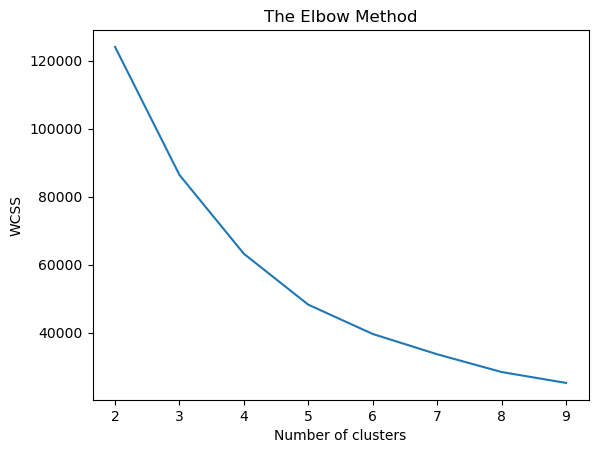

In [26]:
plt.plot(range(2, 10), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

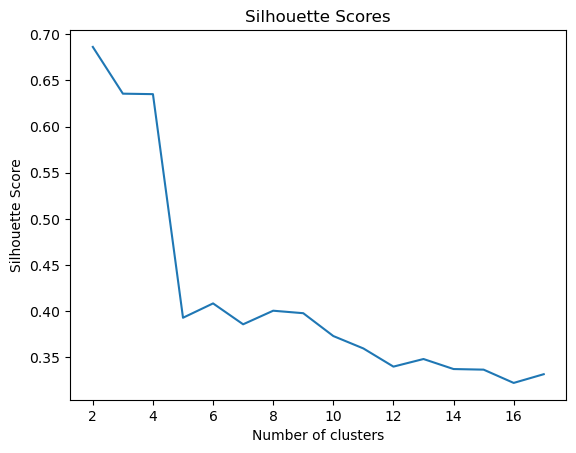

In [27]:
silhouette_scores = []
for i in range(2, 18):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(data2)
    score = silhouette_score(data2, kmeans.labels_)
    silhouette_scores.append(score)

plt.plot(range(2, 18), silhouette_scores)
plt.title('Silhouette Scores')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [28]:
warnings.filterwarnings('ignore')


Probamos con 3 clusters

In [29]:
data2 = dataset[['Curricular units 1st sem (enrolled)', 'Curricular units 2nd sem (enrolled)',
                'Curricular units 1st sem (approved)','Curricular units 2nd sem (approved)',
                 'Curricular units 1st sem (grade)','Curricular units 2nd sem (grade)','Tuition fees up to date',
                 'Target']].copy()
data2.reset_index(drop=True, inplace=True)
if 'cluster' in data1.columns:
    data1.drop(columns=['cluster'], inplace=True)
kmeans = KMeans(n_clusters=3, init="k-means++", random_state=42).fit(data2)
data2['cluster'] = kmeans.labels_
centers = pd.DataFrame(kmeans.cluster_centers_, columns =['Curricular units 1st sem (enrolled)', 'Curricular units 2nd sem (enrolled)',
                'Curricular units 1st sem (approved)','Curricular units 2nd sem (approved)',
                 'Curricular units 1st sem (grade)','Curricular units 2nd sem (grade)','Tuition fees up to date',
                 'Target'])
centers['freq'] = data2['cluster'].value_counts().values
centers['freq_r'] = data2['cluster'].value_counts(normalize=True).values
pd.options.display.float_format = '{:.7f}'.format
print(centers)
centers.to_csv('8var3clus.csv',index=False, sep=';', decimal=',')


   Curricular units 1st sem (enrolled)  Curricular units 2nd sem (enrolled)  \
0                            4.5038589                            4.5644983   
1                            6.2246575                            6.2806697   
2                           13.8275862                           12.0646552   

   Curricular units 1st sem (approved)  Curricular units 2nd sem (approved)  \
0                            0.5402426                            0.0749724   
1                            5.3086758                            5.1908676   
2                           12.4698276                           10.7931034   

   Curricular units 1st sem (grade)  Curricular units 2nd sem (grade)  \
0                         2.5157222                         0.4803749   
1                        12.7390441                        12.7463166   
2                        12.6987931                        12.7224569   

   Tuition fees up to date    Target  freq    freq_r  
0                0

In [30]:
silhouette_scores = silhouette_samples(data2.drop(columns=['cluster']), data2['cluster'])
data2['S_S'] = silhouette_scores
silhouette_score_mean = silhouette_score(data2.drop(columns=['cluster']), data2['cluster'])
print(silhouette_score_mean)

0.6355075959182814


Probamos con 4 clusters

In [31]:
data2 = dataset[['Curricular units 1st sem (enrolled)', 'Curricular units 2nd sem (enrolled)',
                'Curricular units 1st sem (approved)','Curricular units 2nd sem (approved)',
                 'Curricular units 1st sem (grade)','Curricular units 2nd sem (grade)','Tuition fees up to date',
                 'Target']].copy()
data2.reset_index(drop=True, inplace=True)
if 'cluster' in data1.columns:
    data1.drop(columns=['cluster'], inplace=True)
kmeans = KMeans(n_clusters=4, init="k-means++", random_state=42).fit(data2)
data2['cluster'] = kmeans.labels_
centers = pd.DataFrame(kmeans.cluster_centers_, columns =['Curricular units 1st sem (enrolled)', 'Curricular units 2nd sem (enrolled)',
                'Curricular units 1st sem (approved)','Curricular units 2nd sem (approved)',
                 'Curricular units 1st sem (grade)','Curricular units 2nd sem (grade)','Tuition fees up to date',
                 'Target'])
centers['freq'] = data2['cluster'].value_counts().values
centers['freq_r'] = data2['cluster'].value_counts(normalize=True).values
pd.options.display.float_format = '{:.7f}'.format
print(centers)
centers.to_csv('8var4clus.csv',index=False, sep=';', decimal=',')


   Curricular units 1st sem (enrolled)  Curricular units 2nd sem (enrolled)  \
0                            6.2264553                            6.2816215   
1                            4.1603905                            4.2510460   
2                            5.7783505                            5.7422680   
3                           13.8275862                           12.0646552   

   Curricular units 1st sem (approved)  Curricular units 2nd sem (approved)  \
0                            5.3130143                            5.1953673   
1                            0.0000000                            0.1032078   
2                            2.5618557                           -0.0000000   
3                           12.4698276                           10.7931034   

   Curricular units 1st sem (grade)  Curricular units 2nd sem (grade)  \
0                        12.7496556                        12.7482170   
1                         0.0000000                         0.

In [32]:
silhouette_scores = silhouette_samples(data2.drop(columns=['cluster']), data2['cluster'])
data2['S_S'] = silhouette_scores
silhouette_score_mean = silhouette_score(data2.drop(columns=['cluster']), data2['cluster'])
print(silhouette_score_mean)

0.6349495397969722


Probamos con 6 clusters

In [33]:
data2 = dataset[['Curricular units 1st sem (enrolled)', 'Curricular units 2nd sem (enrolled)',
                'Curricular units 1st sem (approved)','Curricular units 2nd sem (approved)',
                 'Curricular units 1st sem (grade)','Curricular units 2nd sem (grade)','Tuition fees up to date',
                 'Target']].copy()
data2.reset_index(drop=True, inplace=True)
if 'cluster' in data1.columns:
    data1.drop(columns=['cluster'], inplace=True)
kmeans = KMeans(n_clusters=6, init="k-means++", random_state=42).fit(data2)
data2['cluster'] = kmeans.labels_
centers = pd.DataFrame(kmeans.cluster_centers_, columns =['Curricular units 1st sem (enrolled)', 'Curricular units 2nd sem (enrolled)',
                'Curricular units 1st sem (approved)','Curricular units 2nd sem (approved)',
                 'Curricular units 1st sem (grade)','Curricular units 2nd sem (grade)','Tuition fees up to date',
                 'Target'])
centers['freq'] = data2['cluster'].value_counts().values
centers['freq_r'] = data2['cluster'].value_counts(normalize=True).values
pd.options.display.float_format = '{:.7f}'.format
print(centers)
centers.to_csv('8var6clus.csv',index=False, sep=';', decimal=',')


   Curricular units 1st sem (enrolled)  Curricular units 2nd sem (enrolled)  \
0                            5.6071189                            5.5977166   
1                            0.0274725                            0.0219780   
2                            6.7662266                            6.8613861   
3                            5.5828571                            5.7028571   
4                            5.7783505                            5.7422680   
5                           14.0462963                           12.2685185   

   Curricular units 1st sem (approved)  Curricular units 2nd sem (approved)  \
0                            4.1155138                            3.8065816   
1                            0.0000000                           -0.0000000   
2                            6.2959296                            6.3415842   
3                            0.0000000                            0.0933333   
4                            2.5618557             

In [34]:
silhouette_scores = silhouette_samples(data2.drop(columns=['cluster']), data2['cluster'])
data2['S_S'] = silhouette_scores
silhouette_score_mean = silhouette_score(data2.drop(columns=['cluster']), data2['cluster'])
print(silhouette_score_mean)

0.40813870178684103


Probamos con 8 clusters

In [35]:
data2 = dataset[['Curricular units 1st sem (enrolled)', 'Curricular units 2nd sem (enrolled)',
                'Curricular units 1st sem (approved)','Curricular units 2nd sem (approved)',
                 'Curricular units 1st sem (grade)','Curricular units 2nd sem (grade)','Tuition fees up to date',
                 'Target']].copy()
data2.reset_index(drop=True, inplace=True)
if 'cluster' in data1.columns:
    data1.drop(columns=['cluster'], inplace=True)
kmeans = KMeans(n_clusters=8, init="k-means++", random_state=42).fit(data2)
data2['cluster'] = kmeans.labels_
centers = pd.DataFrame(kmeans.cluster_centers_, columns =['Curricular units 1st sem (enrolled)', 'Curricular units 2nd sem (enrolled)',
                'Curricular units 1st sem (approved)','Curricular units 2nd sem (approved)',
                 'Curricular units 1st sem (grade)','Curricular units 2nd sem (grade)','Tuition fees up to date',
                 'Target'])
centers['freq'] = data2['cluster'].value_counts().values
centers['freq_r'] = data2['cluster'].value_counts(normalize=True).values
pd.options.display.float_format = '{:.7f}'.format
print(centers)
centers.to_csv('8var8clus.csv',index=False, sep=';', decimal=',')


   Curricular units 1st sem (enrolled)  Curricular units 2nd sem (enrolled)  \
0                            5.9794872                            5.9724359   
1                            5.5870445                            5.7105263   
2                            5.7783505                            5.7422680   
3                           14.7674419                           12.8488372   
4                            7.9829172                            8.1537451   
5                            5.5829244                            5.5662414   
6                            5.3095238                            5.4285714   
7                            0.0274725                            0.0219780   

   Curricular units 1st sem (approved)  Curricular units 2nd sem (approved)  \
0                            5.5884615                            5.4884615   
1                            0.0000000                           -0.0000000   
2                            2.5618557             

In [36]:
silhouette_scores = silhouette_samples(data2.drop(columns=['cluster']), data2['cluster'])
data2['S_S'] = silhouette_scores
silhouette_score_mean = silhouette_score(data2.drop(columns=['cluster']), data2['cluster'])
print(silhouette_score_mean)

0.4003041102443429


### Nuevo intento con 11 variables


In [37]:
data3 = dataset[['Curricular units 1st sem (enrolled)', 'Curricular units 2nd sem (enrolled)',
                'Curricular units 1st sem (approved)','Curricular units 2nd sem (approved)',
                 'Curricular units 1st sem (grade)','Curricular units 2nd sem (grade)','Scholarship holder','Tuition fees up to date',
                 'Age at enrollment', 'Gender','Target']].copy()
data3.reset_index(drop=True, inplace=True)


In [38]:
# Encontrar el número de clusters
# Establecer la variable de entorno OMP_NUM_THREADS
os.environ["OMP_NUM_THREADS"] = "15"
wcss = []
for i in range(2, 15):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42, n_init=10)
    kmeans.fit(data3)
    wcss.append(kmeans.inertia_)

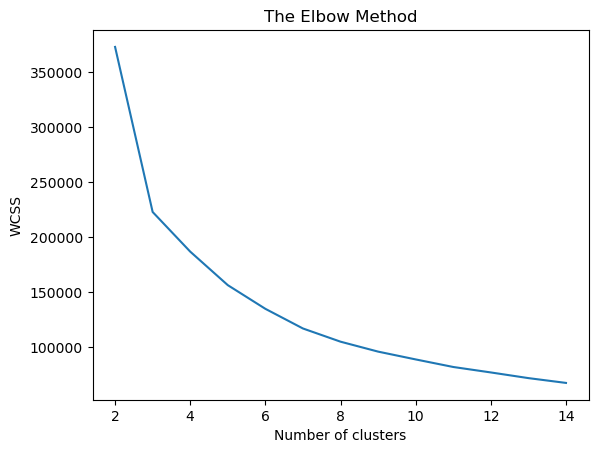

In [39]:
plt.plot(range(2, 15), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

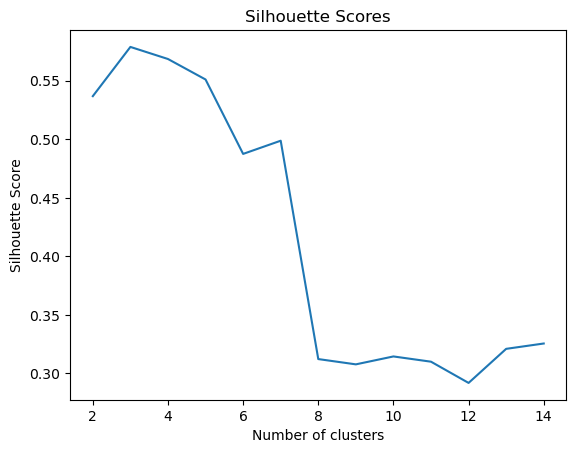

In [40]:
silhouette_scores = []
for i in range(2, 15):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(data3)
    score = silhouette_score(data3, kmeans.labels_)
    silhouette_scores.append(score)

plt.plot(range(2, 15), silhouette_scores)
plt.title('Silhouette Scores')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

Ahora con 3

In [41]:
data3 = dataset[['Curricular units 1st sem (enrolled)', 'Curricular units 2nd sem (enrolled)',
                'Curricular units 1st sem (approved)','Curricular units 2nd sem (approved)',
                 'Curricular units 1st sem (grade)','Curricular units 2nd sem (grade)','Scholarship holder','Tuition fees up to date',
                 'Age at enrollment', 'Gender','Target']].copy()
data3.reset_index(drop=True, inplace=True)
if 'cluster' in data3.columns:
    data3.drop(columns=['cluster'], inplace=True)
kmeans = KMeans(n_clusters=3, init="k-means++", random_state=42).fit(data3)
data3['cluster'] = kmeans.labels_
centers = pd.DataFrame(kmeans.cluster_centers_, columns=['Curricular units 1st sem (enrolled)', 'Curricular units 2nd sem (enrolled)',
                'Curricular units 1st sem (approved)','Curricular units 2nd sem (approved)',
                 'Curricular units 1st sem (grade)','Curricular units 2nd sem (grade)','Scholarship holder','Tuition fees up to date',
                 'Age at enrollment', 'Gender','Target'])
centers['freq'] = data3['cluster'].value_counts().values
centers['freq_r'] = data3['cluster'].value_counts(normalize=True).values
pd.options.display.float_format = '{:.7f}'.format
print(centers)
centers.to_csv('centers11_03.csv', index=True, sep=';', decimal=',')

   Curricular units 1st sem (enrolled)  Curricular units 2nd sem (enrolled)  \
0                            6.5982376                            6.6011749   
1                            7.2364621                            6.8231047   
2                            4.3610422                            4.4230769   

   Curricular units 1st sem (approved)  Curricular units 2nd sem (approved)  \
0                            5.7134465                            5.5456919   
1                            5.3122744                            4.6570397   
2                            0.4627792                            0.0645161   

   Curricular units 1st sem (grade)  Curricular units 2nd sem (grade)  \
0                        12.7735183                        12.7686358   
1                        11.0783394                        10.4910830   
2                         2.2334739                         0.4017370   

   Scholarship holder  Tuition fees up to date  Age at enrollment    Gend

In [42]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
data3['S_S'] = silhouette_samples(data3,data3['cluster'])
silhouette_score_mean = silhouette_score(data3,data3['cluster'])
print(silhouette_score_mean)

0.5804759987715934


Ahora con 4

In [43]:
data3 = dataset[['Curricular units 1st sem (enrolled)', 'Curricular units 2nd sem (enrolled)',
                'Curricular units 1st sem (approved)','Curricular units 2nd sem (approved)',
                 'Curricular units 1st sem (grade)','Curricular units 2nd sem (grade)','Scholarship holder','Tuition fees up to date',
                 'Age at enrollment', 'Gender','Target']].copy()
data3.reset_index(drop=True, inplace=True)
if 'cluster' in data3.columns:
    data3.drop(columns=['cluster'], inplace=True)
kmeans = KMeans(n_clusters=4, init="k-means++", random_state=42).fit(data3)
data3['cluster'] = kmeans.labels_
centers = pd.DataFrame(kmeans.cluster_centers_, columns=['Curricular units 1st sem (enrolled)', 'Curricular units 2nd sem (enrolled)',
                'Curricular units 1st sem (approved)','Curricular units 2nd sem (approved)',
                 'Curricular units 1st sem (grade)','Curricular units 2nd sem (grade)','Scholarship holder','Tuition fees up to date',
                 'Age at enrollment', 'Gender','Target'])
centers['freq'] = data3['cluster'].value_counts().values
centers['freq_r'] = data3['cluster'].value_counts(normalize=True).values
pd.options.display.float_format = '{:.7f}'.format
print(centers)
centers.to_csv('centers11_03.csv', index=True, sep=';', decimal=',')

   Curricular units 1st sem (enrolled)  Curricular units 2nd sem (enrolled)  \
0                            6.5315196                            6.5530856   
1                            4.1735905                            4.2284866   
2                            7.8984064                            7.3207171   
3                            5.4572650                            5.5341880   

   Curricular units 1st sem (approved)  Curricular units 2nd sem (approved)  \
0                            5.6579297                            5.5059721   
1                            0.5385757                            0.0875371   
2                            6.5318725                            5.8904382   
3                            0.5427350                            0.0555556   

   Curricular units 1st sem (grade)  Curricular units 2nd sem (grade)  \
0                        12.7787293                        12.7734373   
1                         2.4769585                         0.

In [44]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
data3['S_S'] = silhouette_samples(data3,data3['cluster'])
silhouette_score_mean = silhouette_score(data3,data3['cluster'])
print(silhouette_score_mean)

0.5709541290954177


Ahora con 5

In [45]:
data3 = dataset[['Curricular units 1st sem (enrolled)', 'Curricular units 2nd sem (enrolled)',
                'Curricular units 1st sem (approved)','Curricular units 2nd sem (approved)',
                 'Curricular units 1st sem (grade)','Curricular units 2nd sem (grade)','Scholarship holder','Tuition fees up to date',
                 'Age at enrollment', 'Gender','Target']].copy()
data3.reset_index(drop=True, inplace=True)
if 'cluster' in data3.columns:
    data3.drop(columns=['cluster'], inplace=True)
kmeans = KMeans(n_clusters=5, init="k-means++", random_state=42).fit(data3)
data3['cluster'] = kmeans.labels_
centers = pd.DataFrame(kmeans.cluster_centers_, columns=['Curricular units 1st sem (enrolled)', 'Curricular units 2nd sem (enrolled)',
                'Curricular units 1st sem (approved)','Curricular units 2nd sem (approved)',
                 'Curricular units 1st sem (grade)','Curricular units 2nd sem (grade)','Scholarship holder','Tuition fees up to date',
                 'Age at enrollment', 'Gender','Target'])
centers['freq'] = data3['cluster'].value_counts().values
centers['freq_r'] = data3['cluster'].value_counts(normalize=True).values
pd.options.display.float_format = '{:.7f}'.format
print(centers)
centers.to_csv('centers11_05.csv', index=True, sep=';', decimal=',')

   Curricular units 1st sem (enrolled)  Curricular units 2nd sem (enrolled)  \
0                            6.2168050                            6.3077455   
1                            4.1723626                            4.2273403   
2                           14.0717949                           12.2923077   
3                            5.4572650                            5.5341880   
4                            6.8209302                            6.4930233   

   Curricular units 1st sem (approved)  Curricular units 2nd sem (approved)  \
0                            5.3641079                            5.2731674   
1                            0.5393759                            0.0817236   
2                           12.6666667                           10.9846154   
3                            0.5427350                            0.0555556   
4                            5.4627907                            5.0325581   

   Curricular units 1st sem (grade)  Curricular un

In [46]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
data3['S_S'] = silhouette_samples(data3,data3['cluster'])
silhouette_score_mean = silhouette_score(data3,data3['cluster'])
print(silhouette_score_mean)

0.5568057057483522


Ahora con 7

In [47]:
data3 = dataset[['Curricular units 1st sem (enrolled)', 'Curricular units 2nd sem (enrolled)',
                'Curricular units 1st sem (approved)','Curricular units 2nd sem (approved)',
                 'Curricular units 1st sem (grade)','Curricular units 2nd sem (grade)','Scholarship holder','Tuition fees up to date',
                 'Age at enrollment', 'Gender','Target']].copy()
data3.reset_index(drop=True, inplace=True)
if 'cluster' in data3.columns:
    data3.drop(columns=['cluster'], inplace=True)
kmeans = KMeans(n_clusters=7, init="k-means++", random_state=42).fit(data3)
data3['cluster'] = kmeans.labels_
centers = pd.DataFrame(kmeans.cluster_centers_, columns=['Curricular units 1st sem (enrolled)', 'Curricular units 2nd sem (enrolled)',
                'Curricular units 1st sem (approved)','Curricular units 2nd sem (approved)',
                 'Curricular units 1st sem (grade)','Curricular units 2nd sem (grade)','Scholarship holder','Tuition fees up to date',
                 'Age at enrollment', 'Gender','Target'])
centers['freq'] = data3['cluster'].value_counts().values
centers['freq_r'] = data3['cluster'].value_counts(normalize=True).values
pd.options.display.float_format = '{:.7f}'.format
print(centers)
centers.to_csv('centers11_05.csv', index=True, sep=';', decimal=',')

   Curricular units 1st sem (enrolled)  Curricular units 2nd sem (enrolled)  \
0                            6.2220970                            6.3201804   
1                            7.2412281                            6.7061404   
2                            5.3467337                            5.4572864   
3                            6.3489933                            6.2595078   
4                            5.7176471                            5.7117647   
5                            3.7725564                            3.8439850   
6                           14.1818182                           12.4278075   

   Curricular units 1st sem (approved)  Curricular units 2nd sem (approved)  \
0                            5.4190154                            5.3355881   
1                            5.9385965                            5.1710526   
2                            0.1658291                            0.0653266   
3                            4.8993289             

In [48]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
data3['S_S'] = silhouette_samples(data3,data3['cluster'])
silhouette_score_mean = silhouette_score(data3,data3['cluster'])
print(silhouette_score_mean)

0.515908004743736


### Nuevo intento con 13 variables


In [49]:
data4 = dataset[['Curricular units 1st sem (enrolled)', 'Curricular units 2nd sem (enrolled)',
                'Curricular units 1st sem (approved)','Curricular units 2nd sem (approved)',
                 'Curricular units 1st sem (grade)','Curricular units 2nd sem (grade)','Scholarship holder','Tuition fees up to date',
                 'Debtor','Age at enrollment', 'Gender','Marital status','Target']].copy()
data4.reset_index(drop=True, inplace=True)


In [50]:
# Encontrar el número de clusters
# Establecer la variable de entorno OMP_NUM_THREADS
os.environ["OMP_NUM_THREADS"] = "15"
wcss = []
for i in range(2, 15):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42, n_init=10)
    kmeans.fit(data4)
    wcss.append(kmeans.inertia_)

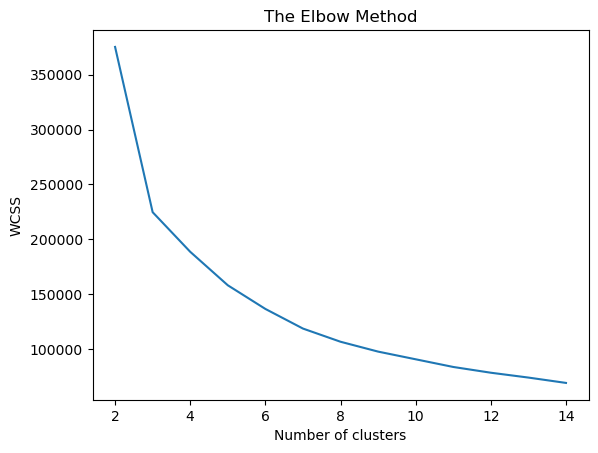

In [51]:
plt.plot(range(2, 15), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

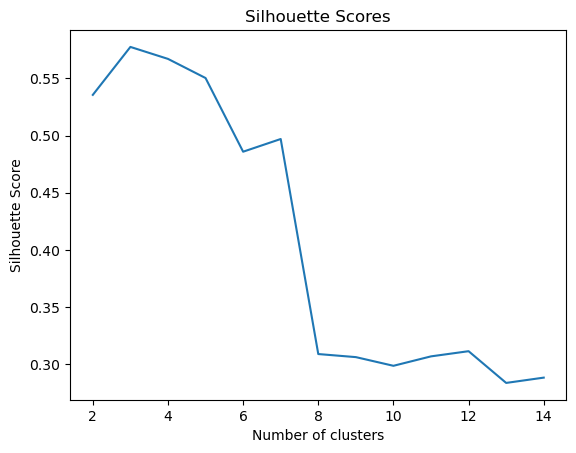

In [52]:
silhouette_scores = []
for i in range(2, 15):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(data4)
    score = silhouette_score(data4, kmeans.labels_)
    silhouette_scores.append(score)

plt.plot(range(2, 15), silhouette_scores)
plt.title('Silhouette Scores')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

Ahora con 3

In [53]:
data4 = dataset[['Curricular units 1st sem (enrolled)', 'Curricular units 2nd sem (enrolled)',
                'Curricular units 1st sem (approved)','Curricular units 2nd sem (approved)',
                 'Curricular units 1st sem (grade)','Curricular units 2nd sem (grade)','Scholarship holder','Tuition fees up to date',
                 'Debtor','Age at enrollment', 'Gender','Marital status','Target']].copy()
data4.reset_index(drop=True, inplace=True)
if 'cluster' in data4.columns:
    data4.drop(columns=['cluster'], inplace=True)
kmeans = KMeans(n_clusters=3, init="k-means++", random_state=42).fit(data4)
data4['cluster'] = kmeans.labels_
centers = pd.DataFrame(kmeans.cluster_centers_, columns=['Curricular units 1st sem (enrolled)', 'Curricular units 2nd sem (enrolled)',
                'Curricular units 1st sem (approved)','Curricular units 2nd sem (approved)',
                 'Curricular units 1st sem (grade)','Curricular units 2nd sem (grade)','Scholarship holder','Tuition fees up to date',
                 'Debtor','Age at enrollment', 'Gender','Marital status','Target'])
centers['freq'] = data4['cluster'].value_counts().values
centers['freq_r'] = data4['cluster'].value_counts(normalize=True).values
pd.options.display.float_format = '{:.7f}'.format
print(centers)
centers.to_csv('centers13_03.csv', index=True, sep=';', decimal=',')

   Curricular units 1st sem (enrolled)  Curricular units 2nd sem (enrolled)  \
0                            6.5968005                            6.6003918   
1                            4.3610422                            4.4230769   
2                            7.2432432                            6.8270270   

   Curricular units 1st sem (approved)  Curricular units 2nd sem (approved)  \
0                            5.7123735                            5.5445642   
1                            0.4627792                            0.0645161   
2                            5.3189189                            4.6648649   

   Curricular units 1st sem (grade)  Curricular units 2nd sem (grade)  \
0                        12.7736990                        12.7690173   
1                         2.2334739                         0.4017370   
2                        11.0803964                        10.4930811   

   Scholarship holder  Tuition fees up to date    Debtor  Age at enrollme

In [54]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
data4['S_S'] = silhouette_samples(data4,data4['cluster'])
silhouette_score_mean = silhouette_score(data4,data4['cluster'])
print(silhouette_score_mean)

0.5788846073292262


Ahora con 4

In [55]:
data4 = dataset[['Curricular units 1st sem (enrolled)', 'Curricular units 2nd sem (enrolled)',
                'Curricular units 1st sem (approved)','Curricular units 2nd sem (approved)',
                 'Curricular units 1st sem (grade)','Curricular units 2nd sem (grade)','Scholarship holder','Tuition fees up to date',
                 'Debtor','Age at enrollment', 'Gender','Marital status','Target']].copy()
data4.reset_index(drop=True, inplace=True)
if 'cluster' in data4.columns:
    data4.drop(columns=['cluster'], inplace=True)
kmeans = KMeans(n_clusters=4, init="k-means++", random_state=42).fit(data4)
data4['cluster'] = kmeans.labels_
centers = pd.DataFrame(kmeans.cluster_centers_, columns=['Curricular units 1st sem (enrolled)', 'Curricular units 2nd sem (enrolled)',
                'Curricular units 1st sem (approved)','Curricular units 2nd sem (approved)',
                 'Curricular units 1st sem (grade)','Curricular units 2nd sem (grade)','Scholarship holder','Tuition fees up to date',
                 'Debtor','Age at enrollment', 'Gender','Marital status','Target'])
centers['freq'] = data4['cluster'].value_counts().values
centers['freq_r'] = data4['cluster'].value_counts(normalize=True).values
pd.options.display.float_format = '{:.7f}'.format
print(centers)
centers.to_csv('centers13_04.csv', index=True, sep=';', decimal=',')

   Curricular units 1st sem (enrolled)  Curricular units 2nd sem (enrolled)  \
0                            6.5315196                            6.5530856   
1                            4.1735905                            4.2284866   
2                            5.4572650                            5.5341880   
3                            7.8984064                            7.3207171   

   Curricular units 1st sem (approved)  Curricular units 2nd sem (approved)  \
0                            5.6579297                            5.5059721   
1                            0.5385757                            0.0875371   
2                            0.5427350                            0.0555556   
3                            6.5318725                            5.8904382   

   Curricular units 1st sem (grade)  Curricular units 2nd sem (grade)  \
0                        12.7787293                        12.7734373   
1                         2.4769585                         0.

In [56]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
data4['S_S'] = silhouette_samples(data4,data4['cluster'])
silhouette_score_mean = silhouette_score(data4,data4['cluster'])
print(silhouette_score_mean)

0.5705214300076477


Ahora con 5

In [57]:
data4 = dataset[['Curricular units 1st sem (enrolled)', 'Curricular units 2nd sem (enrolled)',
                'Curricular units 1st sem (approved)','Curricular units 2nd sem (approved)',
                 'Curricular units 1st sem (grade)','Curricular units 2nd sem (grade)','Scholarship holder','Tuition fees up to date',
                 'Debtor','Age at enrollment', 'Gender','Marital status','Target']].copy()
data4.reset_index(drop=True, inplace=True)
if 'cluster' in data4.columns:
    data4.drop(columns=['cluster'], inplace=True)
kmeans = KMeans(n_clusters=5, init="k-means++", random_state=42).fit(data4)
data4['cluster'] = kmeans.labels_
centers = pd.DataFrame(kmeans.cluster_centers_, columns=['Curricular units 1st sem (enrolled)', 'Curricular units 2nd sem (enrolled)',
                'Curricular units 1st sem (approved)','Curricular units 2nd sem (approved)',
                 'Curricular units 1st sem (grade)','Curricular units 2nd sem (grade)','Scholarship holder','Tuition fees up to date',
                 'Debtor','Age at enrollment', 'Gender','Marital status','Target'])
centers['freq'] = data4['cluster'].value_counts().values
centers['freq_r'] = data4['cluster'].value_counts(normalize=True).values
pd.options.display.float_format = '{:.7f}'.format
print(centers)
centers.to_csv('centers13_05.csv', index=True, sep=';', decimal=',')

   Curricular units 1st sem (enrolled)  Curricular units 2nd sem (enrolled)  \
0                            6.2197650                            6.3099516   
1                            4.1723626                            4.2273403   
2                            5.4572650                            5.5341880   
3                            6.8065268                            6.4801865   
4                           14.1030928                           12.3195876   

   Curricular units 1st sem (approved)  Curricular units 2nd sem (approved)  \
0                            5.3662751                            5.2753974   
1                            0.5393759                            0.0817236   
2                            0.5427350                            0.0555556   
3                            5.4452214                            5.0163170   
4                           12.7113402                           11.0154639   

   Curricular units 1st sem (grade)  Curricular un

In [58]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
data4['S_S'] = silhouette_samples(data4,data4['cluster'])
silhouette_score_mean = silhouette_score(data4,data4['cluster'])
print(silhouette_score_mean)

0.5593609945723554


Ahora con 7

In [59]:
data4 = dataset[['Curricular units 1st sem (enrolled)', 'Curricular units 2nd sem (enrolled)',
                'Curricular units 1st sem (approved)','Curricular units 2nd sem (approved)',
                 'Curricular units 1st sem (grade)','Curricular units 2nd sem (grade)','Scholarship holder','Tuition fees up to date',
                 'Debtor','Age at enrollment', 'Gender','Marital status','Target']].copy()
data4.reset_index(drop=True, inplace=True)
if 'cluster' in data4.columns:
    data4.drop(columns=['cluster'], inplace=True)
kmeans = KMeans(n_clusters=7, init="k-means++", random_state=42).fit(data4)
data4['cluster'] = kmeans.labels_
centers = pd.DataFrame(kmeans.cluster_centers_, columns=['Curricular units 1st sem (enrolled)', 'Curricular units 2nd sem (enrolled)',
                'Curricular units 1st sem (approved)','Curricular units 2nd sem (approved)',
                 'Curricular units 1st sem (grade)','Curricular units 2nd sem (grade)','Scholarship holder','Tuition fees up to date',
                 'Debtor','Age at enrollment', 'Gender','Marital status','Target'])
centers['freq'] = data4['cluster'].value_counts().values
centers['freq_r'] = data4['cluster'].value_counts(normalize=True).values
pd.options.display.float_format = '{:.7f}'.format
print(centers)
centers.to_csv('centers13_07.csv', index=True, sep=';', decimal=',')

   Curricular units 1st sem (enrolled)  Curricular units 2nd sem (enrolled)  \
0                            6.2227648                            6.3208114   
1                            3.7725564                            3.8439850   
2                            5.3500000                            5.4600000   
3                            7.2466960                            6.7092511   
4                           14.1818182                           12.4278075   
5                            5.7176471                            5.7117647   
6                            6.3452915                            6.2556054   

   Curricular units 1st sem (approved)  Curricular units 2nd sem (approved)  \
0                            5.4199850                            5.3365890   
1                            0.0000000                            0.1127820   
2                            0.1700000                            0.0650000   
3                            5.9603524             

In [60]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
data4['S_S'] = silhouette_samples(data4,data4['cluster'])
silhouette_score_mean = silhouette_score(data4,data4['cluster'])
print(silhouette_score_mean)

0.5412127665286898


### Nuevo intento con 16 variables


In [61]:
data5 = dataset[['Curricular units 1st sem (enrolled)', 'Curricular units 2nd sem (enrolled)',
                'Curricular units 1st sem (approved)','Curricular units 2nd sem (approved)',
                 'Curricular units 1st sem (grade)','Curricular units 2nd sem (grade)','Scholarship holder','Tuition fees up to date',
                 'Debtor','Age at enrollment', 'Gender','Marital status',
                 'Previous qualification (grade)', 'Admission grade', 'Displaced','Target']].copy()
data5.reset_index(drop=True, inplace=True)


In [62]:
# Encontrar el número de clusters
# Establecer la variable de entorno OMP_NUM_THREADS
os.environ["OMP_NUM_THREADS"] = "15"
wcss = []
for i in range(2, 18):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42, n_init=10)
    kmeans.fit(data5)
    wcss.append(kmeans.inertia_)

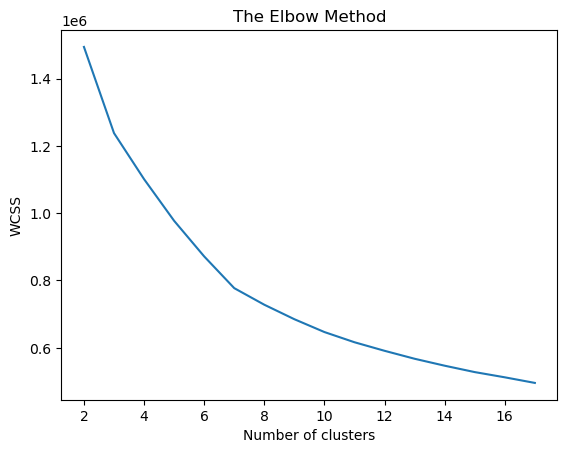

In [63]:
plt.plot(range(2, 18), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

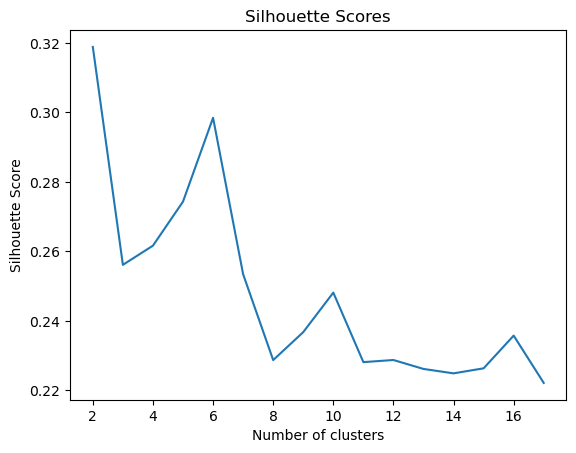

In [64]:
silhouette_scores = []
for i in range(2, 18):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(data5)
    score = silhouette_score(data5, kmeans.labels_)
    silhouette_scores.append(score)

plt.plot(range(2, 18), silhouette_scores)
plt.title('Silhouette Scores')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

Ahora con 3

In [65]:
data5 = dataset[['Curricular units 1st sem (enrolled)', 'Curricular units 2nd sem (enrolled)',
                'Curricular units 1st sem (approved)','Curricular units 2nd sem (approved)',
                 'Curricular units 1st sem (grade)','Curricular units 2nd sem (grade)','Scholarship holder','Tuition fees up to date',
                 'Debtor','Age at enrollment', 'Gender','Marital status',
                 'Previous qualification (grade)', 'Admission grade', 'Displaced','Target']].copy()
data5.reset_index(drop=True, inplace=True)
if 'cluster' in data5.columns:
    data5.drop(columns=['cluster'], inplace=True)
kmeans = KMeans(n_clusters=3, init="k-means++", random_state=42).fit(data5)
data5['cluster'] = kmeans.labels_
centers = pd.DataFrame(kmeans.cluster_centers_, columns=['Curricular units 1st sem (enrolled)', 'Curricular units 2nd sem (enrolled)',
                'Curricular units 1st sem (approved)','Curricular units 2nd sem (approved)',
                 'Curricular units 1st sem (grade)','Curricular units 2nd sem (grade)','Scholarship holder','Tuition fees up to date',
                 'Debtor','Age at enrollment', 'Gender','Marital status',
                 'Previous qualification (grade)', 'Admission grade', 'Displaced','Target'])
centers['freq'] = data5['cluster'].value_counts().values
centers['freq_r'] = data5['cluster'].value_counts(normalize=True).values
pd.options.display.float_format = '{:.7f}'.format
print(centers)
centers.to_csv('centers18_3.csv', index=True, sep=';', decimal=',')

   Curricular units 1st sem (enrolled)  Curricular units 2nd sem (enrolled)  \
0                            6.3805017                            6.3781354   
1                            6.0176056                            5.9119718   
2                            6.2197361                            6.1594951   

   Curricular units 1st sem (approved)  Curricular units 2nd sem (approved)  \
0                            5.0160909                            4.8182679   
1                            4.9471831                            4.5669014   
2                            4.2530120                            3.9294320   

   Curricular units 1st sem (grade)  Curricular units 2nd sem (grade)  \
0                        11.0483909                        10.7807951   
1                        11.1498768                        10.5840141   
2                         9.9812163                         9.4477453   

   Scholarship holder  Tuition fees up to date    Debtor  Age at enrollme

In [66]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
data5['S_S'] = silhouette_samples(data5,data5['cluster'])
silhouette_score_mean = silhouette_score(data5,data5['cluster'])
print(silhouette_score_mean)

0.2581914891239522


Ahora con 6

In [67]:
data5 = dataset[['Curricular units 1st sem (enrolled)', 'Curricular units 2nd sem (enrolled)',
                'Curricular units 1st sem (approved)','Curricular units 2nd sem (approved)',
                 'Curricular units 1st sem (grade)','Curricular units 2nd sem (grade)','Scholarship holder','Tuition fees up to date',
                 'Debtor','Age at enrollment', 'Gender','Marital status',
                 'Previous qualification (grade)', 'Admission grade', 'Displaced','Target']].copy()
data5.reset_index(drop=True, inplace=True)
if 'cluster' in data5.columns:
    data5.drop(columns=['cluster'], inplace=True)
kmeans = KMeans(n_clusters=6, init="k-means++", random_state=42).fit(data5)
data5['cluster'] = kmeans.labels_
centers = pd.DataFrame(kmeans.cluster_centers_, columns=['Curricular units 1st sem (enrolled)', 'Curricular units 2nd sem (enrolled)',
                'Curricular units 1st sem (approved)','Curricular units 2nd sem (approved)',
                 'Curricular units 1st sem (grade)','Curricular units 2nd sem (grade)','Scholarship holder','Tuition fees up to date',
                 'Debtor','Age at enrollment', 'Gender','Marital status',
                 'Previous qualification (grade)', 'Admission grade', 'Displaced','Target'])
centers['freq'] = data5['cluster'].value_counts().values
centers['freq_r'] = data5['cluster'].value_counts(normalize=True).values
pd.options.display.float_format = '{:.7f}'.format
print(centers)
centers.to_csv('centers18_6.csv', index=True, sep=';', decimal=',')

   Curricular units 1st sem (enrolled)  Curricular units 2nd sem (enrolled)  \
0                            6.7655875                            6.7763789   
1                            5.9296066                            5.8281573   
2                            6.7777778                            6.5390947   
3                            6.5073892                            6.3128079   
4                            6.3625325                            6.3269731   
5                            4.1762208                            4.2590234   

   Curricular units 1st sem (approved)  Curricular units 2nd sem (approved)  \
0                            5.9430456                            5.7967626   
1                            4.9358178                            4.5797101   
2                            4.9547325                            4.4156379   
3                            3.8817734                            3.3226601   
4                            4.8777103             

In [68]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
data5['S_S'] = silhouette_samples(data5,data5['cluster'])
silhouette_score_mean = silhouette_score(data5,data5['cluster'])
print(silhouette_score_mean)

0.3071050262762501


Ahora con 7

In [69]:
data5 = dataset[['Curricular units 1st sem (enrolled)', 'Curricular units 2nd sem (enrolled)',
                'Curricular units 1st sem (approved)','Curricular units 2nd sem (approved)',
                 'Curricular units 1st sem (grade)','Curricular units 2nd sem (grade)','Scholarship holder','Tuition fees up to date',
                 'Debtor','Age at enrollment', 'Gender','Marital status',
                 'Previous qualification (grade)', 'Admission grade', 'Displaced','Target']].copy()
data5.reset_index(drop=True, inplace=True)
if 'cluster' in data5.columns:
    data5.drop(columns=['cluster'], inplace=True)
kmeans = KMeans(n_clusters=7, init="k-means++", random_state=42).fit(data5)
data5['cluster'] = kmeans.labels_
centers = pd.DataFrame(kmeans.cluster_centers_, columns=['Curricular units 1st sem (enrolled)', 'Curricular units 2nd sem (enrolled)',
                'Curricular units 1st sem (approved)','Curricular units 2nd sem (approved)',
                 'Curricular units 1st sem (grade)','Curricular units 2nd sem (grade)','Scholarship holder','Tuition fees up to date',
                 'Debtor','Age at enrollment', 'Gender','Marital status',
                 'Previous qualification (grade)', 'Admission grade', 'Displaced','Target'])
centers['freq'] = data5['cluster'].value_counts().values
centers['freq_r'] = data5['cluster'].value_counts(normalize=True).values
pd.options.display.float_format = '{:.7f}'.format
print(centers)
centers.to_csv('centers18_6.csv', index=True, sep=';', decimal=',')

   Curricular units 1st sem (enrolled)  Curricular units 2nd sem (enrolled)  \
0                            6.8152296                            6.8286674   
1                            4.1441048                            4.2183406   
2                            6.4220779                            6.3454545   
3                            5.6834734                            5.5714286   
4                            6.4986523                            6.2884097   
5                            6.5569811                            6.5735849   
6                            6.7360000                            6.4920000   

   Curricular units 1st sem (approved)  Curricular units 2nd sem (approved)  \
0                            6.0369541                            5.8510638   
1                            0.2183406                            0.0393013   
2                            4.6896104                            4.3363636   
3                            4.6330532             

In [70]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
data5['S_S'] = silhouette_samples(data5,data5['cluster'])
silhouette_score_mean = silhouette_score(data5,data5['cluster'])
print(silhouette_score_mean)

0.26990184392046707
